## Project: Ventilation in the CCU
### EDA: Ventilator Mode in the CCU Cohort
### C.V. Cosgriff
#### NYU CCU Data Science Group


__Question:__ Can you guys please see how many of the 756 patients received receive SIMV or IMV as the mode of mechanical ventilation. A very interesting (and relatively simple) analysis would be to compare length of stay, mortality, ventilator free days and MV duration between those undergoing SIMV/IMV and other modes.

### Analysis Plan
* Extract the CCU Metavision Cohort with basic demographic data
* Identify the `itemid` for ventilator mode
* Extract the ventilator mode items for each patient on the first day
* Decide how to summarise if multiple modes exist
* Assign patients to each group and compare unadjusted mortality
* Build logistic regression model for hospital mortality
* Build Poisson model for length of stay

## 0 - Environment

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import psycopg2
dbname = 'mimic'
schema_name = 'mimiciii'
db_schema = 'SET search_path TO {0};'.format(schema_name)
con = psycopg2.connect(database=dbname)

## 1 - CCU Cohort Extraction

In [3]:
query = db_schema + '''
SELECT ie.icustay_id, ie.hadm_id, ie.subject_id, ie.dbsource
       , ie.first_careunit, ie.intime, ie.outtime, ie.los
       , ied.admission_age, ied.gender, ied.ethnicity
       , ied.first_icu_stay, oa.oasis AS oasis_score
       , elix.elixhauser_vanwalraven AS elixhauser_score
       , vd.starttime AS vent_start, vd.endtime AS vent_end
       , ad.hospital_expire_flag
FROM icustays ie
LEFT JOIN icustay_detail ied
    ON ie.icustay_id = ied.icustay_id
LEFT JOIN admissions ad
    ON ie.hadm_id = ad.hadm_id
LEFT JOIN elixhauser_ahrq_score elix
    ON ie.hadm_id = elix.hadm_id
LEFT JOIN oasis oa
    ON ie.icustay_id = oa.icustay_id
LEFT JOIN ventdurations vd
    ON ie.icustay_id = vd.icustay_id;
'''
cohort_df = pd.read_sql(query, con)
print(cohort_df.shape)
display(cohort_df.head())

(73298, 17)


,icustay_id,hadm_id,subject_id,dbsource,first_careunit,intime,outtime,los,admission_age,gender,ethnicity,first_icu_stay,oasis_score,elixhauser_score,vent_start,vent_end,hospital_expire_flag
0,200014,127229,9514,carevue,SICU,2105-02-16 23:16:48,2105-02-18 16:53:29,1.7338,84.7300,M,UNKNOWN/NOT SPECIFIED,True,56,12,2105-02-16 23:15:00,2105-02-17 18:00:00,0
1,200017,135069,15909,carevue,NICU,2138-03-17 21:54:36,2138-05-14 17:12:41,57.8042,0.0025,M,WHITE,True,34,0,2138-03-17 22:00:00,2138-03-21 09:00:00,0
2,200024,179633,76603,metavision,MICU,2127-03-03 16:09:07,2127-03-04 01:18:06,0.3812,80.3979,F,BLACK/AFRICAN AMERICAN,False,32,21,2127-03-03 16:00:00,2127-03-03 20:00:00,1
3,200033,198650,56369,metavision,SICU,2198-08-07 17:56:17,2198-08-21 14:59:18,13.8771,67.1466,M,WHITE,True,24,23,2198-08-10 17:23:00,2198-08-20 12:20:00,1
4,200037,150812,21695,carevue,NICU,2141-08-07 09:29:48,2141-08-25 17:16:56,18.3244,0.0011,F,WHITE,True,36,0,2141-08-07 09:00:00,2141-08-07 20:00:00,0


In [4]:
cohort_df = cohort_df.loc[cohort_df.dbsource == 'metavision', :]
cohort_df = cohort_df.loc[cohort_df.first_careunit == 'CCU', :]
cohort_df = cohort_df.loc[cohort_df.admission_age >= 16, :]
cohort_df = cohort_df.drop('dbsource', axis=1)

In [6]:
cohort_df.drop_duplicates(subset='icustay_id').shape

(2772, 16)

## 2 - Identify Ventilator Mode Items

In [7]:
query = db_schema + '''
SELECT itemid, label, dbsource, linksto 
FROM d_items 
WHERE LOWER(label) LIKE '%mode%'
AND dbsource='metavision';
'''

d_search = pd.read_sql_query(query, con)
display(d_search)

,itemid,label,dbsource,linksto
0,227290,CRRT mode,metavision,chartevents
1,223956,Temporary Pacemaker Mode,metavision,chartevents
2,227577,BiPap Mode,metavision,chartevents
3,224712,Recruitment Mode,metavision,chartevents
4,224844,Permanent Pacemaker Mode,metavision,chartevents
5,227850,Commode,metavision,chartevents
6,223849,Ventilator Mode,metavision,chartevents


It appears the `itemid` is __223849__.

## 3 - Extract Ventilation Modes

In [36]:
query = db_schema + '''
WITH vent_mode_day1 AS (
    SELECT ce.icustay_id, ce.charttime - ie.intime AS offset
    , ce.value
    FROM icustays ie
    LEFT JOIN chartevents ce
        ON ie.icustay_id = ce.icustay_id
    WHERE ce.itemid = 223849
)
SELECT vm.icustay_id, vm.value AS vent_mode_24h
FROM vent_mode_day1 vm
WHERE vm.offset <= interval '24' hour;
'''

vm_df = pd.read_sql(query, con)
display(vm_df.head())

,icustay_id,vent_mode_24h
0,239587,CPAP/PSV
1,239587,CPAP/PSV
2,239587,CPAP/PSV
3,244588,CPAP/PSV
4,272392,CMV/ASSIST


Lets look at the distribution of different ventilation modes in this data.

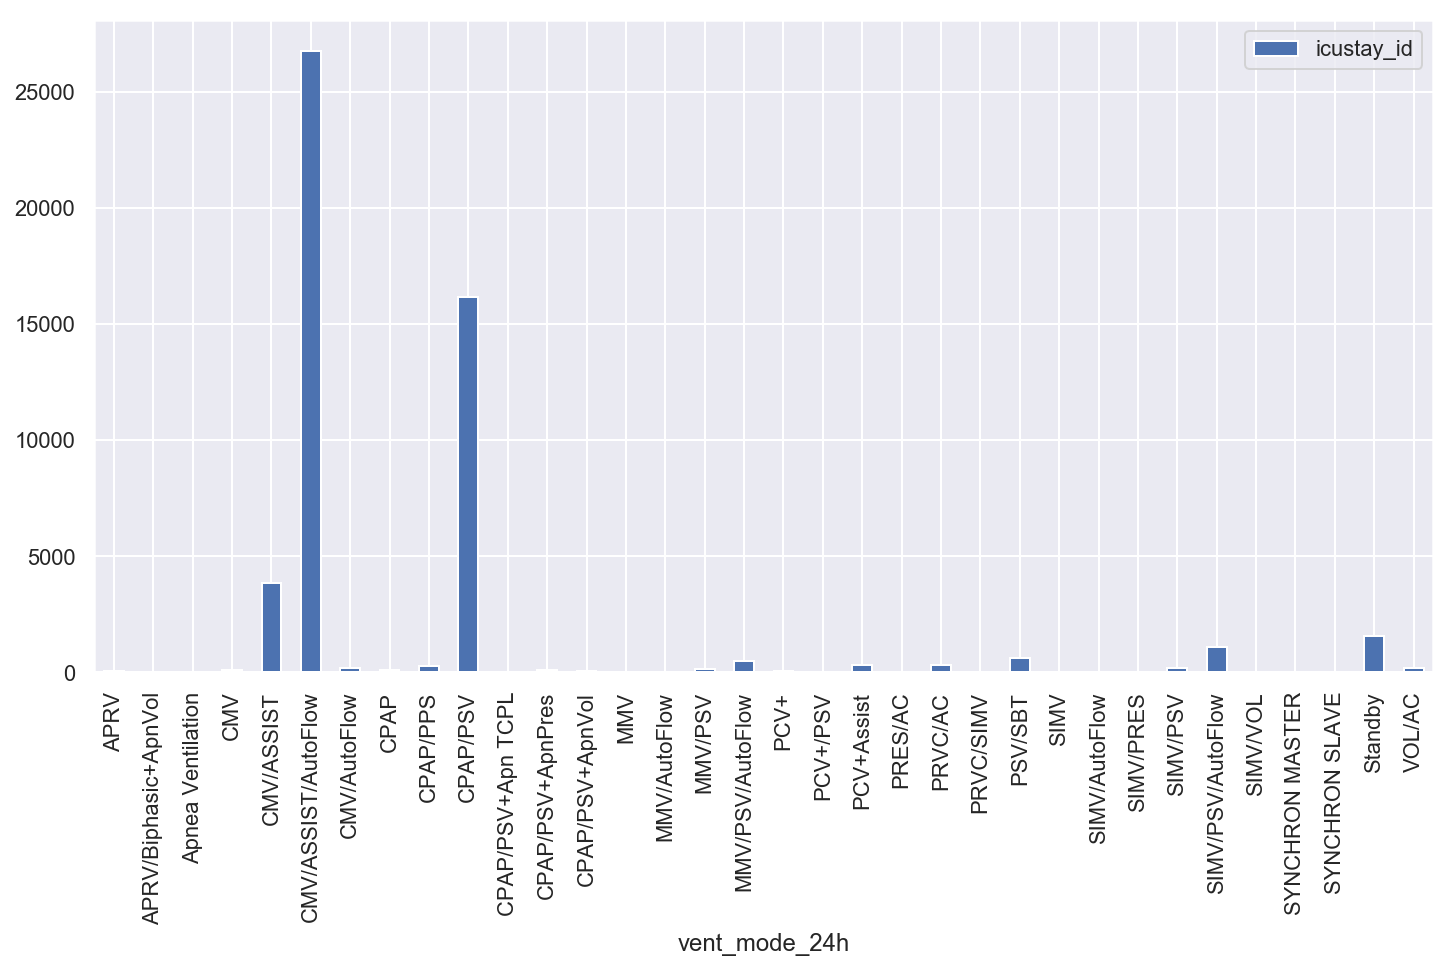

In [37]:
vm_df.groupby(vm_df.vent_mode_24h).count().plot(kind='bar', figsize=(12,6))

Will stop here for now to consult with team about these modes.